In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

import string   
from nltk.stem import PorterStemmer    
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec

from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



**Multi label binarization**

In [ ]:
train_df = pd.read_csv('/content/train_df.csv')
test_df = pd.read_csv('/content/test_df.csv')
validation_df = pd.read_csv('/content/val_df.csv')

In [ ]:
def split_tags(train_df):

  tags = []
  for i in range(0, len(train_df)):
    train_df.at[i, 'tags'] = re.sub("[^\w]", " ", train_df.at[i, 'tags']).split()
    tags += train_df.at[i,'tags']

  return train_df

In [ ]:
test_df = split_tags(test_df)

In [ ]:
train_df = split_tags(train_df)
validation = split_tags(validation_df)

In [ ]:
train_df

,text,tags
0,Des milliers de Philippins fuyaient dimanche l...,"[Philippines, News, Monde, Intempéries]"
1,Il n'a fallu que 66 minutes à Roger Federer (A...,[]
2,Die UN-Menschenrechts-Charta sowie die meisten...,"[Schweiz, News, Panorama, UNK]"
3,"Le plan de restructuration de Lundbeck, annonc...",[]
4,"Le Sacré-Coeur à Plainpalais, Sainte-Pétronill...",[]
...,...,...
129058,Geoge Bush stammt nicht aus Texas. Präsident d...,"[London, News, Klamauk, Kurioses, UNK]"
129059,"Die US-Schauspielerin Joan Leslie, die mit Sta...","[USA, News, Kunst, Kultur, Film]"
129060,Environ 1100 migrants ont été secourus dans le...,"[UNK, News, Monde, UNK]"
129061,"Le taux pivot est passé à 6,3306 yuans pour un...","[News, Chine, Economie]"


**Text preprocessing**

In [ ]:
train_df['text'][20]

'<a href="http://www.20min.ch/schweiz/news/story/-Viele-wollen-vermeintlich-bequeme-Buerojobs--22090775" target="_blank">In der Schweiz sind immer mehr junge Menschen arbeitslos.</a> Laut der schweizerischen Arbeitskräfteerhebung (Sake) lag die Jugendarbeitslosenquote bei den 15- bis 24-Jährigen vergangenes Jahr bei 8,6 Prozent. Zum Vergleich: 1998 lag der Anteil bei 5,8 Prozent.\n\n<!--[articleElementIndex:0]--> \n\n<!--[articleElementIndex:1]-->«Viele Jugendliche stehen nach abgeschlossener Lehre oder nach dem Studium vor der Frage, wie es nun weitergeht und ob sie allenfalls Anspruch auf Arbeitslosenentschädigung haben», sagt Natasa Radisavljevic, Kommunikationsverantwortliche bei der Unia Arbeitslosenkasse. Einige würden in die Rekrutenschule einrücken und sich fragen, wie es vor und nach der RS aussehe. Generell sei eine grosse Unwissenheit feststellbar. Das will die Unia Arbeitslosenkasse ändern, indem sie den jungen Betroffenen deren Pflichten und Rechte kommuniziert.\n\nHaben a

In [ ]:
def is_ascii(s):
    # removes all words consisting with non-alphabet char or numbers
    return all(ord(c) < 123 and ord(c) > 96 for c in s)

In [ ]:
hiperlink_string = ' [URL] '
mention_string = ' '
article_element_string = ' '

In [ ]:
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))

In [ ]:
def preprocess_data(df):

  df['tokens'] = " "
  
  for i in range(0,len(df)):
    
    # remove html elements
    text = df.at[i,'text'].lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'</blockquote>|<blockquote class="[^\s\n\r]+" lang="de">', ' ', text)
    text = re.sub(r'<!--\[articleElementIndex:[0-9]+\]-->', article_element_string, text)
    text = re.sub(r'<a href="https?://[^\s\n\r]+">\@?\#?(.*?)</a>', hiperlink_string, text)
    text = re.sub(r'#', ' ', text)
    text = re.sub(r"@\w+", mention_string, text) 
    text = re.sub(r'<script async="async" src="https?://[^\s\n\r]+" charset="utf-8"></script>', ' ', text)
    text = re.sub(r"<[^>]+>", ' ', text)

    # tokenization
    df.at[i,'tokens'] = word_tokenize(text)

    # remove unvalid tokens
    tokens_clean = []
    for word in df.at[i,'tokens']: 
      if (word not in stop_words and word not in string.punctuation and is_ascii(word)):
        tokens_clean.append(stemmer.stem(word)) 
      if len(tokens_clean) > 0:
        df.at[i,'tokens'] = tokens_clean
      else:
        df.at[i,'tokens'] = ''

  return df

In [ ]:
train_df = preprocess_data(train_df)

In [ ]:
test_df = preprocess_data(test_df)

In [ ]:
validation_df = preprocess_data(validation_df)

In [ ]:
train_df

,text,tags,tokens
0,Des milliers de Philippins fuyaient dimanche l...,"[Philippines, News, Monde, Intempéries]","[milli, de, philippin, fuyaient, dimanch, les,..."
1,Il n'a fallu que 66 minutes à Roger Federer (A...,[],"[il, n, a, fallu, que, minut, rog, fed, atp, p..."
2,Die UN-Menschenrechts-Charta sowie die meisten...,"[Schweiz, News, Panorama, UNK]","[sowi, meist, staat, stell, straf, darunt, sch..."
3,"Le plan de restructuration de Lundbeck, annonc...",[],"[le, plan, de, restructuration, de, lundbeck, ..."
4,"Le Sacré-Coeur à Plainpalais, Sainte-Pétronill...",[],"[le, plainpalais, et, maintenant, hermanc, les..."
...,...,...,...
129058,Geoge Bush stammt nicht aus Texas. Präsident d...,"[London, News, Klamauk, Kurioses, UNK]","[geog, bush, stammt, texas, usa, nie, namensve..."
129059,"Die US-Schauspielerin Joan Leslie, die mit Sta...","[USA, News, Kunst, Kultur, Film]","[joan, lesli, star, humphrey, bogart, gary, co..."
129060,Environ 1100 migrants ont été secourus dans le...,"[UNK, News, Monde, UNK]","[environ, migrant, ont, secourus, dan, le, can..."
129061,"Le taux pivot est passé à 6,3306 yuans pour un...","[News, Chine, Economie]","[le, taux, pivot, est, yuan, pour, un, dollar,..."


In [ ]:
train_df.at[20, 'text']

'<a href="http://www.20min.ch/schweiz/news/story/-Viele-wollen-vermeintlich-bequeme-Buerojobs--22090775" target="_blank">In der Schweiz sind immer mehr junge Menschen arbeitslos.</a> Laut der schweizerischen Arbeitskräfteerhebung (Sake) lag die Jugendarbeitslosenquote bei den 15- bis 24-Jährigen vergangenes Jahr bei 8,6 Prozent. Zum Vergleich: 1998 lag der Anteil bei 5,8 Prozent.\n\n<!--[articleElementIndex:0]--> \n\n<!--[articleElementIndex:1]-->«Viele Jugendliche stehen nach abgeschlossener Lehre oder nach dem Studium vor der Frage, wie es nun weitergeht und ob sie allenfalls Anspruch auf Arbeitslosenentschädigung haben», sagt Natasa Radisavljevic, Kommunikationsverantwortliche bei der Unia Arbeitslosenkasse. Einige würden in die Rekrutenschule einrücken und sich fragen, wie es vor und nach der RS aussehe. Generell sei eine grosse Unwissenheit feststellbar. Das will die Unia Arbeitslosenkasse ändern, indem sie den jungen Betroffenen deren Pflichten und Rechte kommuniziert.\n\nHaben a

In [ ]:
train_df.at[20, 'tokens']

['schweiz',
 'imm',
 'mehr',
 'jung',
 'mensch',
 'arbeitslos',
 'laut',
 'schweizer',
 'sak',
 'lag',
 'jugendarbeitslosenquot',
 'vergang',
 'jahr',
 'prozent',
 'vergleich',
 'lag',
 'anteil',
 'prozent',
 'viel',
 'jugend',
 'steh',
 'abgeschloss',
 'lehr',
 'studium',
 'frag',
 'weitergeht',
 'allenfall',
 'anspruch',
 'sagt',
 'natasa',
 'radisavljevic',
 'kommunikationsverantwort',
 'unia',
 'arbeitslosenkass',
 'rekrutenschul',
 'frag',
 'rs',
 'ausseh',
 'generell',
 'sei',
 'gross',
 'unwiss',
 'feststellbar',
 'unia',
 'arbeitslosenkass',
 'jung',
 'betroff',
 'der',
 'pflicht',
 'recht',
 'kommuniziert',
 'ausbild',
 'job',
 'gefund',
 'geschicht',
 'stell',
 'frag',
 'fachexpert',
 'unia',
 'arbeitslosenkass',
 'beantwortet',
 'morg',
 'uhr',
 'frag',
 'dp']

**One-hot encode labels**

In [ ]:
tags = []
for i in range(0, len(train_df)):
  tags += [tag for tag in train_df.at[i, 'tags']]

tags = list(set(tags))

tags = tf.ragged.constant(tags)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(tags)
vocab = lookup.get_vocabulary()

In [ ]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [ ]:
sample_label = train_df["tags"].iloc[20]
print(f"Original label: {sample_label}")

label_binarized = lookup(sample_label)
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Schweiz', 'Leser', 'Aufruf', 'Arbeit', 'Désirée', 'Pomper']
Label-binarized representation: [0. 0. 0. ... 0. 0. 0.]


In [ ]:
batch_size = 128

def make_dataset(dataframe, X, is_train=True):
    labels = tf.ragged.constant(dataframe["tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices((X, label_binarized))
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

**Vectorization**

In [ ]:
max_seqlen = 387
batch_size = 128
padding_token = "<pad>"

In [ ]:
def parse_data(data):

  sentence = []
  vocabulary = set()

  for i in range(0,len(data)):
    list_of_words = data.iloc[i]['tokens']
    sentence.append(list_of_words)
    vocabulary = vocabulary.union(set(list_of_words))

  return sentence, vocabulary

def fit_tokenizer(sentences):
    """
    Instantiates the Tokenizer class
    Args:
        sentences (list): lower-cased sentences without stopwords
    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """
    tokenizer = Tokenizer(oov_token = '', num_words=len(vocabulary))
    tokenizer.fit_on_texts(sentences)

    return tokenizer

def get_padded_sequences(tokenizer, sentences):
    """
    Generates an array of token sequences and pads them to the same length
    Args:
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        sentences (list of string): list of sentences to tokenize and pad
    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, padding = 'post', maxlen=max_seqlen)
    
    return padded_sequences  

In [ ]:
sentence_train, vocabulary = parse_data(train_df)
sentence_test,_ = parse_data(test_df)
sentence_validation,_ = parse_data(validation_df)

tokenizer = fit_tokenizer(sentence_train)
word_index = tokenizer.word_index

In [ ]:
padded_sequence_train = get_padded_sequences(tokenizer, sentence_train)
padded_sequence_test = get_padded_sequences(tokenizer, sentence_test)
padded_sequence_validation = get_padded_sequences(tokenizer, sentence_validation)

In [ ]:
padded_sequence_train[20]

array([    45,    106,     43,    232,    123,   3926,    103,   1677,
        40462,    483,  77168,    248,     39,     92,   1059,    483,
         2512,     92,    101,    785,    379,   2867,   1912,   5924,
          322,   9760,   4698,   3750,     36, 130141, 171883,  38343,
         4457,  49336,  27666,    322,  17369,   2853,   3106,     46,
           96,  20613,  33417,   4457,  49336,    232,    527,    787,
         4187,    576,   7721,   2803,   1244,    955,    951,    462,
          322,  84580,   4457,  49336,   6248,   1126,    214,    322,
        51397,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
train_dataset = make_dataset(train_df, padded_sequence_train, is_train=True)
test_dataset = make_dataset(test_df,padded_sequence_test, is_train=False)
validation_dataset = make_dataset(validation_df, padded_sequence_validation, is_train=False)

**Model**

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=3, restore_best_weights=True)

In [ ]:
# Parameters
vocab_size = len(vocabulary)
max_length = 387
embedding_dim = 100
oov_tok = ""

def make_model():
    model = tf.keras.Sequential(
        [   tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
            tf.keras.layers.LSTM(128),
            tf.keras.layers.Dense(512, activation="relu"),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),]  
    )
    return model

In [ ]:
model = make_model()
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

In [ ]:
epochs = 20
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[es])


Epoch 1/20
1009/1009 [==============================] - 158s 155ms/step - loss: 0.0126 - categorical_accuracy: 0.0475 - val_loss: 0.0127 - val_categorical_accuracy: 0.0500
Epoch 2/20
1009/1009 [==============================] - 429s 425ms/step - loss: 0.0126 - categorical_accuracy: 0.0475 - val_loss: 0.0127 - val_categorical_accuracy: 0.0500
Epoch 3/20
1009/1009 [==============================] - 246s 244ms/step - loss: 0.0126 - categorical_accuracy: 0.0475 - val_loss: 0.0127 - val_categorical_accuracy: 0.0500
Epoch 4/20
1009/1009 [==============================] - 160s 158ms/step - loss: 0.0126 - categorical_accuracy: 0.0475 - val_loss: 0.0127 - val_categorical_accuracy: 0.0500
Epoch 5/20
1009/1009 [==============================] - 216s 214ms/step - loss: 0.0125 - categorical_accuracy: 0.0475 - val_loss: 0.0125 - val_categorical_accuracy: 0.0500
Epoch 6/20
1009/1009 [==============================] - 120s 119ms/step - loss: 0.0118 - categorical_accuracy: 0.0475 - val_loss: 0.0113 - v

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 387, 100)          29710900  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 512)               66048     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 1676)              430732    
                                                                 
Total params: 30,456,256
Trainable params: 30,456,256
Non-trainable params: 0
_________________________________________________________________


**Train model metrics**

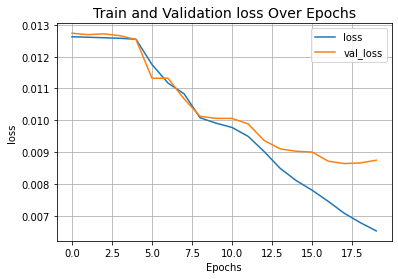

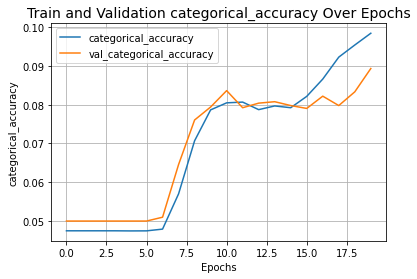

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

**Evaluation**

In [ ]:
_, categorical_acc = model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

127/127 [==============================] - 14s 106ms/step - loss: 0.0086 - categorical_accuracy: 0.0844
Categorical accuracy on the test set: 8.44%.


In [ ]:
y_pred_train = model.predict(test_dataset)

127/127 [==============================] - 9s 69ms/step


Tags:
['Deutschland', 'Reaktion', 'Sport', 'Fussball', 'Bundesliga', 'UNK', 'UNK']
Prediction:
['UNK' 'Sport' 'News' 'München' 'League' 'Fussball' 'FC' 'Europa'
 'England' 'Dortmund' 'Deutschland' 'Champions' 'Bundesliga' 'Borussia'
 'Bayern']


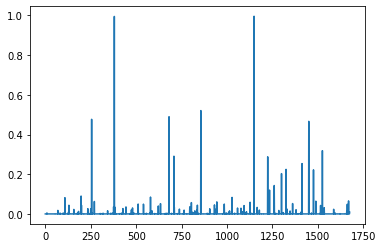

In [ ]:
ind = 10005
print('Tags:')
print(test_df['tags'][ind])
print('Prediction:')
labels = preprocessing.Binarizer(threshold=0.1).transform(y_pred_train[ind].reshape([1,len(y_pred_train[0])]))[0]
print(invert_multi_hot(labels))
plt.plot(y_pred_train[ind])

In [ ]:
test_df.at[ind, 'text']

'«Ich wurde zweimal geblitzt, ohne dass ich zu schnell war», sagt der 52-jährige Kurt Kleindienst aus Herisau. Er sei beide Male mit weniger als 50 Stundenkilometern am semistationären Blitzkasten an der Gossauerstrasse vorbeigefahren – trotzdem habe es geblitzt. «Ich war unmöglich zu schnell, da mein Auto neu ist und der Tacho mit dem GPS übereinstimmt», so Kleindienst. An dieser Stelle sei die Höchstgeschwindigkeit 50 Kilometer pro Stunde und er sei mit 48 und 50 km/h erfasst worden. Kleindienst vermutet, dass es etwas mit den Wetterverhältnissen zu tun hatte: «An beiden Abenden regnete es.»\n\n<!--[articleElementIndex:0]-->Daraufhin meldete er sich bei der Kantonspolizei Ausserrhoden. «Sie gaben an, ich müsse nicht mit einer Busse rechnen und sagten, dass sie schon mehrfach Meldungen bekommen hatten von Radarkästen die grundlos blitzten.»\n\n<!--[articleElementIndex:1]--><b>Kantonspolizei geht auf Fehlersuche</b>\n\nHanspeter Saxer, Mediensprecher der Kantonspolizei Ausserrhoden, be